# IMPORTS

In [1]:
import sys
sys.path.append('/content/drive/MyDrive/Romanian-Sign-Language-Image-Classification/utils_fn')

In [2]:
from tensorflow import keras
from keras import layers, models, utils
import numpy as np
from pathlib import Path
from generate_dataset import *
from plot_history import *
from generate_classification_report import *
from plot_confusion_matrix import *
from predict_image import *

utils.set_random_seed(42)

# CONSTANTS

In [3]:
SAVE_NAME = f'Model with augmentation and dropout'
DATASET_DIR = Path("/content/drive/MyDrive/Romanian-Sign-Language-Image-Classification/Ro_Sign_language_Dataset")
MODEL_SAVE_DIR = Path("/content/drive/MyDrive/Romanian-Sign-Language-Image-Classification/Saves")

BATCH_SIZE = 64
IMAGE_SIZE = (128, 128)
EPOCHS = 50

# PREPROCESSING

In [4]:
train_dataset, validation_dataset, test_dataset = generate_dataset(base_dir=DATASET_DIR, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE)

Found 15600 files belonging to 26 classes.
Found 5200 files belonging to 26 classes.
Found 5200 files belonging to 26 classes.


In [ ]:
data_augmentation = keras.Sequential([layers.RandomFlip("horizontal"),
                                      layers.RandomRotation(0.05),
                                      layers.RandomZoom(0.2)])

rescale = layers.Rescaling(1./255)

# TRAINING



## ARCHITECTURE

In [ ]:
inputs = keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
x = data_augmentation(inputs)
x = rescale(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(26, activation="softmax")(x)
aug_drop_model = keras.Model(inputs=inputs, outputs=outputs)

aug_drop_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 61, 61, 64)        18496     
                                                           

In [ ]:
aug_drop_model.compile(loss="categorical_crossentropy",
                       optimizer="adam",
                       metrics=["accuracy"])

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath = str(MODEL_SAVE_DIR / SAVE_NAME / f'{SAVE_NAME}.model.keras'),
                                             save_best_only=True,
                                             monitor="val_loss")]

history = aug_drop_model.fit(train_dataset,
                       epochs=EPOCHS,
                       validation_data=validation_dataset,
                       callbacks=callbacks)

np.save(MODEL_SAVE_DIR / SAVE_NAME / f'{SAVE_NAME}.history.npy', history.history)
bare_model.save(MODEL_SAVE_DIR / SAVE_NAME / f'{SAVE_NAME}.model.h5', save_format='h5')

Epoch 1/50
244/244 [==============================] - 31s 115ms/step - loss: 2.7634 - accuracy: 0.1822 - val_loss: 2.0995 - val_accuracy: 0.3677
Epoch 2/50
244/244 [==============================] - 28s 111ms/step - loss: 1.0858 - accuracy: 0.6609 - val_loss: 0.9255 - val_accuracy: 0.7019
Epoch 3/50
244/244 [==============================] - 28s 111ms/step - loss: 0.5048 - accuracy: 0.8368 - val_loss: 0.9994 - val_accuracy: 0.7313
Epoch 4/50
244/244 [==============================] - 28s 111ms/step - loss: 0.3138 - accuracy: 0.8972 - val_loss: 0.5624 - val_accuracy: 0.8473
Epoch 5/50
244/244 [==============================] - 27s 110ms/step - loss: 0.2303 - accuracy: 0.9292 - val_loss: 0.4814 - val_accuracy: 0.8538
Epoch 6/50
244/244 [==============================] - 28s 110ms/step - loss: 0.1756 - accuracy: 0.9426 - val_loss: 0.4679 - val_accuracy: 0.8571
Epoch 7/50
244/244 [==============================] - 28s 111ms/step - loss: 0.1499 - accuracy: 0.9502 - val_loss: 0.3764 - val_ac

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


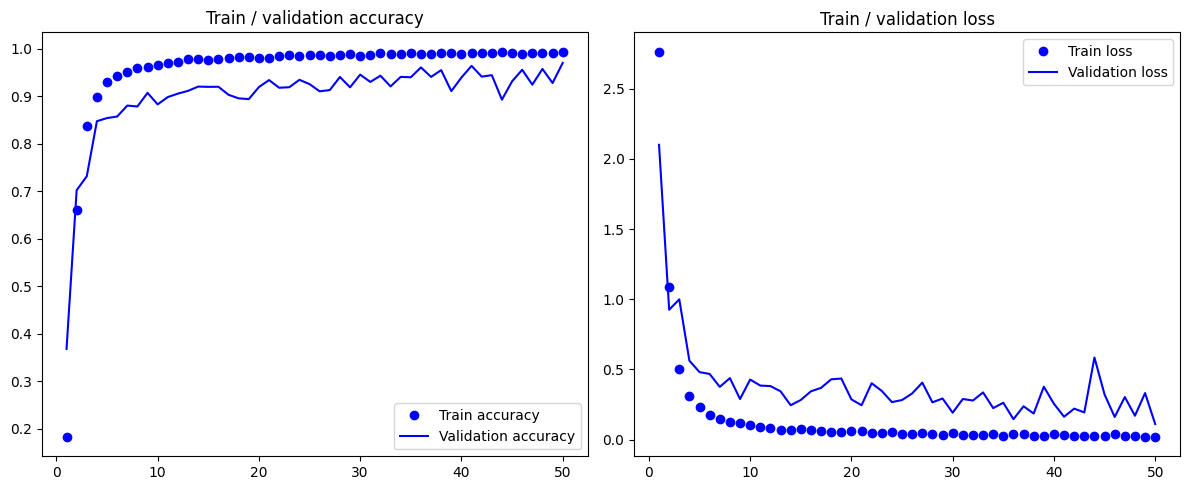

In [9]:
history = np.load(MODEL_SAVE_DIR / SAVE_NAME / f'{SAVE_NAME}.history.npy', allow_pickle=True).item()

plot_history(history)

## EVALUATION

In [5]:
aug_drop_model = keras.models.load_model(MODEL_SAVE_DIR / SAVE_NAME / f'{SAVE_NAME}.model.keras')
test_loss, test_acc = aug_drop_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

82/82 [==============================] - 16s 186ms/step - loss: 1.4208 - accuracy: 0.8567
Test accuracy: 0.857


In [6]:
generate_classification_report(aug_drop_model, test_dataset)

82/82 [==============================] - 15s 177ms/step
              precision    recall  f1-score   support

           A       0.45      0.99      0.62       200
          Â       0.92      1.00      0.96       200
          Ă       1.00      0.98      0.99       200
           B       1.00      1.00      1.00       200
           C       0.98      1.00      0.99       200
           D       0.97      0.88      0.92       200
           E       0.98      0.80      0.88       200
           F       0.95      0.93      0.94       200
           G       0.99      0.98      0.99       200
           H       0.99      0.94      0.96       200
           I       0.96      0.93      0.94       200
           K       0.90      0.98      0.94       200
           L       0.98      1.00      0.99       200
           M       0.54      1.00      0.70       200
           N       1.00      0.12      0.21       200
           O       0.95      1.00      0.97       200
           P       0.94  

82/82 [==============================] - 20s 238ms/step


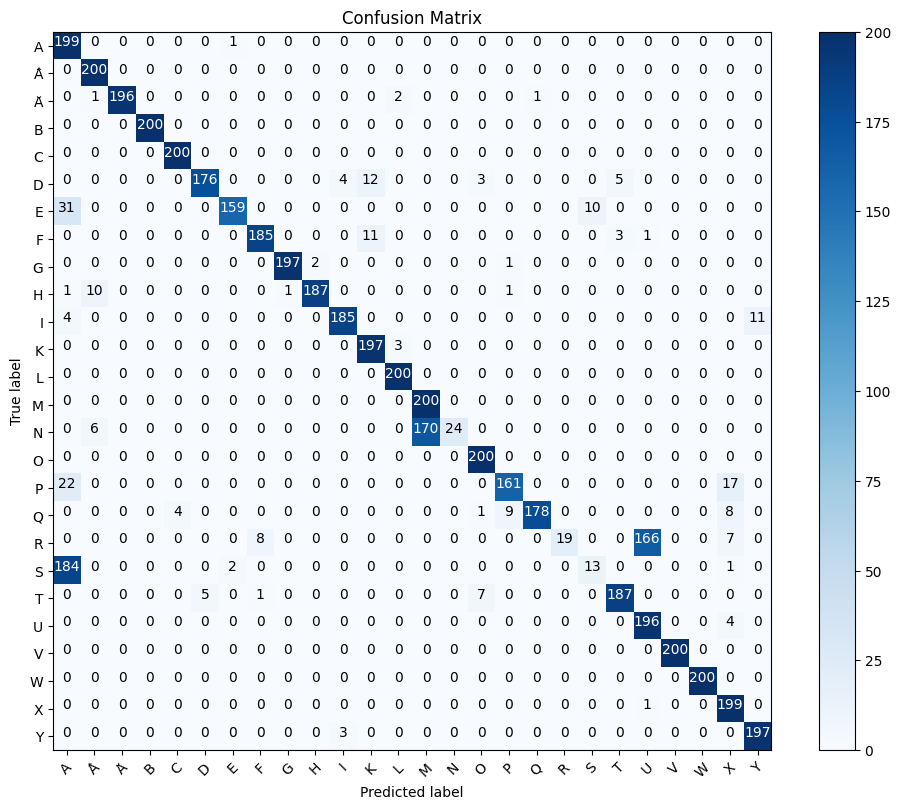

In [7]:
plot_confusion_matrix(aug_drop_model, test_dataset)